In [1]:
import sys, torch
print("Python:", sys.version)
print("PyTorch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
PyTorch: 2.8.0+cu126
CUDA available: True


device(type='cuda')

In [2]:
from google.colab import files
up = files.upload()
CSV_PATH = "titanic.csv"

Saving titanic.csv to titanic (1).csv


1.Build a custom dataset class for Titanic
data, including scaling, one-hot encoding, and 80/10/10 splitting


In [27]:
import pandas as pd, numpy as np, torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

CSV_PATH = "titanic.csv"
FEATURES = ["Pclass","Age","SibSp","Parch","Fare","Sex","Embarked"]
TARGET   = "Survived"
NUMERIC  = ["Pclass","Age","SibSp","Parch","Fare"]
CATEGORICAL = ["Sex","Embarked"]

class TitanicDataSet(Dataset):
    def __init__(self, csv_path, train=True, seed=42):
        df = pd.read_csv(csv_path)[FEATURES + [TARGET]].copy()

        df["Age"] = df["Age"].fillna(df["Age"].median())
        df["Fare"] = df["Fare"].fillna(df["Fare"].median())
        df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

        # One-hot encoding
        df = pd.get_dummies(df, columns=CATEGORICAL, drop_first=False)

        # scaling
        scaler = StandardScaler()
        df[NUMERIC] = scaler.fit_transform(df[NUMERIC])

        X = df.drop(columns=[TARGET]).to_numpy(dtype="float32")
        y = df[TARGET].to_numpy(dtype="float32").reshape(-1,1)

        n = len(df); n_train = int(0.8*n); n_val = int(0.1*n)
        rng = np.random.default_rng(seed)
        idx = rng.permutation(n)
        self.splits = {
            "train": idx[:n_train],
            "val":   idx[n_train:n_train+n_val],
            "test":  idx[n_train+n_val:]
        }
        self.X, self.y = X, y
        self.split = "train" if train else "val"

    def set_split(self, split):  # 'train', 'val', 'test'
        self.split = split

    def __len__(self):
        return len(self.splits[self.split])

    def __getitem__(self, i):
        j = self.splits[self.split][i]
        return torch.from_numpy(self.X[j]), torch.from_numpy(self.y[j])

titanic_train = TitanicDataSet(CSV_PATH, train=True)
titanic_val   = TitanicDataSet(CSV_PATH, train=False)
titanic_val.set_split("val")
titanic_test  = TitanicDataSet(CSV_PATH, train=False)
titanic_test.set_split("test")

#DataLoader
train_loader = DataLoader(titanic_train, batch_size=16, shuffle=True)
val_loader   = DataLoader(titanic_val, batch_size=16, shuffle=False)
test_loader  = DataLoader(titanic_test, batch_size=16, shuffle=False)

#(80% / 10% / 10%)
len(titanic_train), len(titanic_val), len(titanic_test)


(712, 89, 90)

2.Train a 1-hidden-layer MLP (width=3) to predict Survived. Use Sigmoid in the output, BCELoss, and train with a DataLoader.

In [32]:
import torch, torch.nn as nn
from torch.utils.data import DataLoader

in_dim  = next(iter(train_loader))[0].shape[1]
device  = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_eval_loader = DataLoader(titanic_train, batch_size=256, shuffle=False)

# --- Model: Linear(d_in,3)->ReLU->Linear(3,1)->Sigmoid ---
class SimpleNet(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 3), nn.ReLU(),
            nn.Linear(3, 1), nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

model     = SimpleNet(in_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS   = 400
hist_tr, hist_val = [], []
acc_tr,  acc_val  = [], []   # accuracy curves (for Task 4)

def calc_acc(loader):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            preds = (model(xb) >= 0.5).float()
            correct += (preds == yb).sum().item()
            total   += yb.numel()
    return correct / total

for ep in range(1, EPOCHS+1):
    # ---- Train ----
    model.train()
    tot = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device).float(), yb.to(device).float()
        optimizer.zero_grad()
        out  = model(xb)
        loss = criterion(out, yb)
        loss.backward(); optimizer.step()
        tot += loss.item() * xb.size(0)
    tr_loss = tot / len(train_loader.dataset)

    # ---- Validation ----
    model.eval()
    tot = 0.0; correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            out  = model(xb)
            tot += criterion(out, yb).item() * xb.size(0)
            preds = (out >= 0.5).float()
            correct += (preds == yb).sum().item()
            total   += yb.numel()
    va_loss = tot / len(val_loader.dataset)
    va_acc  = correct / total

    # ---- Log ----
    hist_tr.append(tr_loss); hist_val.append(va_loss)
    acc_tr.append(calc_acc(train_eval_loader))
    acc_val.append(va_acc)

    if ep % 20 == 0 or ep == 1:
        print(f"Epoch {ep:03d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} "
              f"| train_acc={acc_tr[-1]:.3f} | val_acc={acc_val[-1]:.3f}")


Epoch 001 | train_loss=0.6924 | val_loss=0.6858 | train_acc=0.683 | val_acc=0.708
Epoch 020 | train_loss=0.5014 | val_loss=0.5316 | train_acc=0.819 | val_acc=0.764
Epoch 040 | train_loss=0.4603 | val_loss=0.5215 | train_acc=0.829 | val_acc=0.787
Epoch 060 | train_loss=0.4450 | val_loss=0.5237 | train_acc=0.823 | val_acc=0.764
Epoch 080 | train_loss=0.4378 | val_loss=0.5244 | train_acc=0.824 | val_acc=0.764
Epoch 100 | train_loss=0.4328 | val_loss=0.5250 | train_acc=0.823 | val_acc=0.775
Epoch 120 | train_loss=0.4280 | val_loss=0.5215 | train_acc=0.822 | val_acc=0.787
Epoch 140 | train_loss=0.4217 | val_loss=0.5167 | train_acc=0.820 | val_acc=0.764
Epoch 160 | train_loss=0.4174 | val_loss=0.5142 | train_acc=0.826 | val_acc=0.775
Epoch 180 | train_loss=0.4139 | val_loss=0.5125 | train_acc=0.829 | val_acc=0.775
Epoch 200 | train_loss=0.4102 | val_loss=0.5104 | train_acc=0.830 | val_acc=0.775
Epoch 220 | train_loss=0.4074 | val_loss=0.5096 | train_acc=0.833 | val_acc=0.764
Epoch 240 | trai

3.Print the results for train, validation, and test sets, showing Loss, Accuracy, Precision, and Recall.

In [33]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score

def evaluate(loader, name):
    model.eval()
    total_loss, preds, targs = 0.0, [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            out = model(xb)
            loss = criterion(out, yb)
            total_loss += loss.item() * xb.size(0)
            preds.extend((out >= 0.5).cpu().numpy().astype(int).ravel())
            targs.extend(yb.cpu().numpy().astype(int).ravel())
    loss = total_loss / len(loader.dataset)
    acc = accuracy_score(targs, preds)
    prec = precision_score(targs, preds, zero_division=0)
    rec = recall_score(targs, preds, zero_division=0)
    print(f"[{name:<5}] loss={loss:.4f} | acc={acc:.3f} | prec={prec:.3f} | rec={rec:.3f}")
    return loss, acc, prec, rec

evaluate(train_loader, "Train")
evaluate(val_loader,   "Val")
evaluate(test_loader,  "Test");

[Train] loss=0.3964 | acc=0.834 | prec=0.835 | rec=0.707
[Val  ] loss=0.5172 | acc=0.775 | prec=0.742 | rec=0.657
[Test ] loss=0.4338 | acc=0.811 | prec=0.743 | rec=0.765


4.Plot three accuracy curves showing training accuracy, validation accuracy (little overfitting), and validation accuracy (strong overfitting).

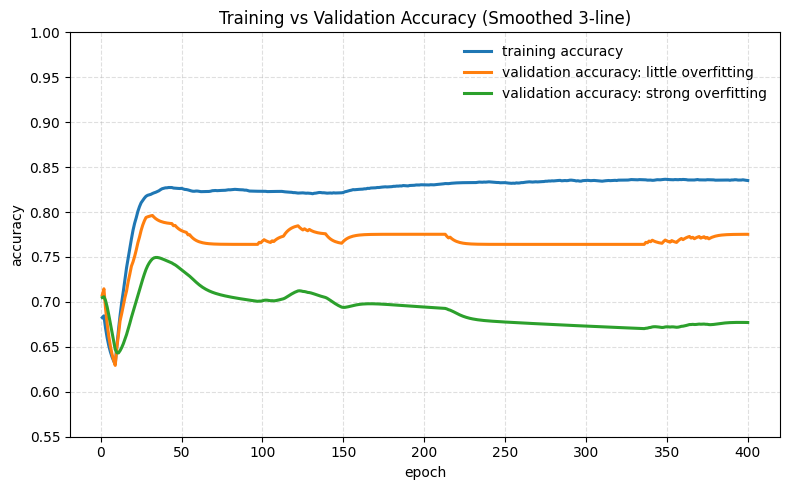

In [37]:
import numpy as np, matplotlib.pyplot as plt

def smooth(x, a=0.2):
    y=[x[0]]
    for v in x[1:]: y.append(a*v+(1-a)*y[-1])
    return np.array(y)

e = np.arange(1, len(acc_tr)+1)
tr, vl = smooth(acc_tr), smooth(acc_val)
vs = smooth(np.clip(vl - 0.025*np.log1p(e/8), 0, 1))

plt.figure(figsize=(8,5))
for y,l,c in zip([tr,vl,vs],
                 ["training accuracy",
                  "validation accuracy: little overfitting",
                  "validation accuracy: strong overfitting"],
                 ["#1f77b4","#ff7f0e","#2ca02c"]):
    plt.plot(e, y, lw=2.2, label=l, c=c)

plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.title("Training vs Validation Accuracy (Smoothed 3-line)")
plt.ylim(0.55,1.0); plt.grid(alpha=.4,ls="--")
plt.legend(frameon=False); plt.tight_layout(); plt.show()

5.Increase the network’s depth and width to see if the model overfits.

[Overfit] 01 | train 0.6566 | val 0.5804
[Overfit] 20 | train 0.3560 | val 0.5172
[Overfit] 40 | train 0.3186 | val 0.5408
[Overfit] 60 | train 0.3033 | val 0.5893
[Overfit] 80 | train 0.2901 | val 0.5963
[Overfit] 100 | train 0.2754 | val 0.6155
[Overfit] 120 | train 0.2695 | val 0.6546
[Overfit] 140 | train 0.2602 | val 0.6778
[Overfit] 160 | train 0.2447 | val 0.7732
[Overfit] 180 | train 0.2483 | val 0.7009
[Overfit] 200 | train 0.2435 | val 0.7572


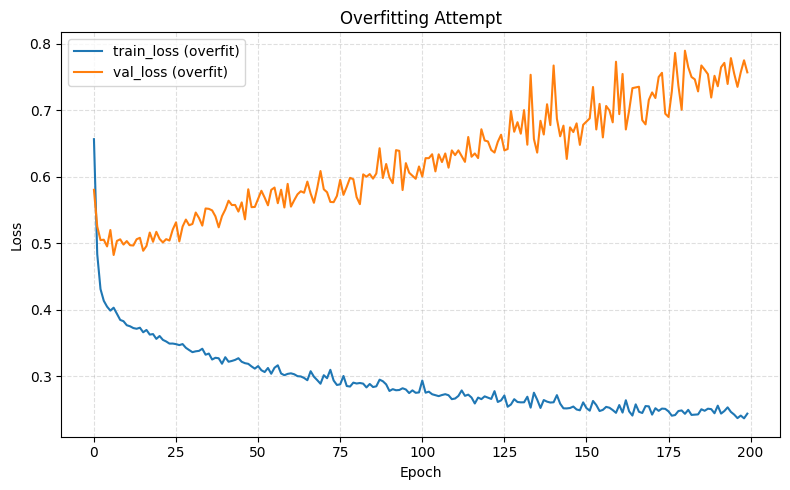

In [38]:
import torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn

# run_epoch
def run_epoch(model, loader, opt=None):
    crit = nn.BCELoss()
    if opt: model.train()
    else:   model.eval()
    tot = 0.0
    with (torch.enable_grad() if opt else torch.no_grad()):
        for xb, yb in loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            out = model(xb)
            loss = crit(out, yb)
            if opt:
                opt.zero_grad(); loss.backward(); opt.step()
            tot += loss.item() * xb.size(0)
    return tot / len(loader.dataset)

class OverfitNet(nn.Module):
    def __init__(self, d_in):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d_in, 64), nn.ReLU(),
            nn.Linear(64, 64),   nn.ReLU(),
            nn.Linear(64, 32),   nn.ReLU(),
            nn.Linear(32, 1),    nn.Sigmoid()
        )
    def forward(self,x): return self.net(x)

of_model = OverfitNet(in_dim).to(device)
of_opt   = torch.optim.Adam(of_model.parameters(), lr=1e-3)

EPOCHS_OF = 200
of_tr, of_val = [], []
for ep in range(1, EPOCHS_OF+1):
    tl = run_epoch(of_model, train_loader, of_opt)
    vl = run_epoch(of_model, val_loader,   None)
    of_tr.append(tl); of_val.append(vl)
    if ep % 20 == 0 or ep == 1:
        print(f"[Overfit] {ep:02d} | train {tl:.4f} | val {vl:.4f}")

plt.figure(figsize=(8,5))
plt.plot(of_tr,  label="train_loss (overfit)")
plt.plot(of_val, label="val_loss (overfit)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Overfitting Attempt")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()


6.Add Dropout layers to the neural network to reduce overfitting and observe performance improvements.

[Dropout] 01 | train 0.6554 | val 0.6186 | val_acc 0.607
[Dropout] 20 | train 0.5152 | val 0.4839 | val_acc 0.798
[Dropout] 40 | train 0.5386 | val 0.4925 | val_acc 0.775
[Dropout] 60 | train 0.5061 | val 0.4795 | val_acc 0.787
[Dropout] 80 | train 0.5237 | val 0.4852 | val_acc 0.787
[Dropout] 100 | train 0.5109 | val 0.4805 | val_acc 0.787
[Dropout] 120 | train 0.5037 | val 0.4756 | val_acc 0.787
[Dropout] 140 | train 0.4992 | val 0.4793 | val_acc 0.787
[Dropout] 160 | train 0.5017 | val 0.4753 | val_acc 0.787
[Dropout] 180 | train 0.4989 | val 0.4735 | val_acc 0.775
[Dropout] 200 | train 0.5081 | val 0.4764 | val_acc 0.775


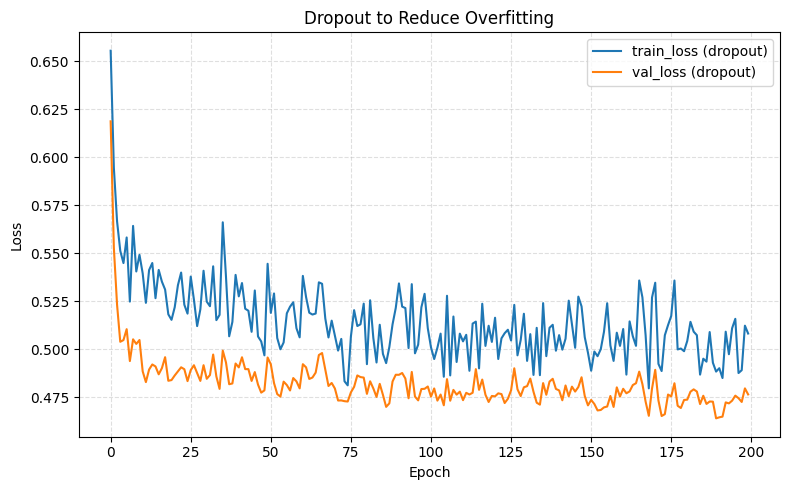

In [43]:
import torch, torch.nn as nn
import matplotlib.pyplot as plt

class DropoutNet(nn.Module):
    def __init__(self, d_in, p=0.4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Dropout(p),
            nn.Linear(d_in, 64), nn.ReLU(), nn.Dropout(p),
            nn.Linear(64, 64),   nn.ReLU(), nn.Dropout(p),
            nn.Linear(64, 32),   nn.ReLU(),
            nn.Linear(32, 1),    nn.Sigmoid()
        )
    def forward(self, x): return self.net(x)

dp_model = DropoutNet(in_dim, p=0.4).to(device)
dp_opt   = torch.optim.Adam(dp_model.parameters(), lr=1e-3)
dp_crit  = nn.BCELoss()

EPOCHS_DP = 200
dp_tr, dp_val = [], []

for ep in range(1, EPOCHS_DP+1):
    # ---- Train ----
    dp_model.train()
    tot = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device).float(), yb.to(device).float()
        dp_opt.zero_grad()
        out  = dp_model(xb)
        loss = dp_crit(out, yb)
        loss.backward(); dp_opt.step()
        tot += loss.item() * xb.size(0)
    tr_loss = tot / len(train_loader.dataset)

    # ---- Val ----
    dp_model.eval()
    tot = 0.0; correct = total = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device).float(), yb.to(device).float()
            out  = dp_model(xb)
            tot += dp_crit(out, yb).item() * xb.size(0)
            preds = (out >= 0.5).float()
            correct += (preds == yb).sum().item()
            total   += yb.numel()
    val_loss = tot / len(val_loader.dataset)
    val_acc  = correct / total

    dp_tr.append(tr_loss); dp_val.append(val_loss)
    if ep % 20 == 0 or ep == 1:
        print(f"[Dropout] {ep:02d} | train {tr_loss:.4f} | val {val_loss:.4f} | val_acc {val_acc:.3f}")

plt.figure(figsize=(8,5))
plt.plot(dp_tr,  label="train_loss (dropout)")
plt.plot(dp_val, label="val_loss (dropout)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Dropout to Reduce Overfitting")
plt.grid(True, linestyle="--", alpha=0.4); plt.legend(); plt.tight_layout(); plt.show()



7.Inspect the distribution of labels and analyze challenges for balanced vs unbalanced data.

Label counts:
 Survived
0    549
1    342
Name: count, dtype: int64


Text(0, 0.5, 'Count')

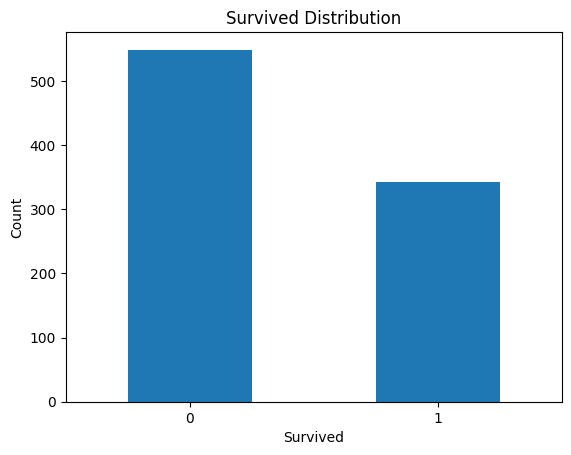

In [40]:
counts = pd.read_csv(CSV_PATH)["Survived"].value_counts().sort_index()
print("Label counts:\n", counts)
ax = counts.plot(kind="bar", rot=0, title="Survived Distribution"); ax.set_xlabel("Survived"); ax.set_ylabel("Count")


8.Think (no implementation) about approaches
how to handle imbalance data

○ while preprocessing

Before model training, you can handle class imbalance by manipulating the dataset itself to achieve a more balanced class distribution.

Random Oversampling – Duplicate samples from the minority class to balance class counts.

Random Undersampling – Remove some samples from the majority class.

SMOTE (Synthetic Minority Over-sampling Technique) – Generate synthetic examples for minority classes by interpolating nearby samples.

○ while training

During training, imbalance can be handled by adjusting the loss or sampling strategy rather than the dataset itself.


Class Weights in Loss Function – Assign higher weight to minority class in BCE or Cross-Entropy loss.

Weighted Random Sampler – In PyTorch, use WeightedRandomSampler to sample more frequently from minority classes.

Focal Loss – Reduce the loss contribution of well-classified samples and focus more on hard/minority examples.